### Stacked Generalization Ensemble Model

Model ensemble is a technique where multiple sub-models contribute to a consolidated prediction. Model ensemble can typically be done via (weighted) average ensemble, however a more generalized approach is to use an algorithm that takes the outputs of the sub-models as input and try to learn how to best combine the output from sub-models as input to achieve a better final prediction.

It is important to train the meta-learner on a different dataset from the dataset used to train the sub-models to avoid overfitting. 
An easy way to do is to by splitting the dataset into traning and validation. The sub-models are then trained on the training dataset, while afterwards the meta-learner get trained by the validation dataset (validation dataset still get fed through sub-models to the meta-learner).
A more sophisticated way is to use k-fold cross validation.

In [9]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from numpy import argmax
import os
from os import makedirs
from IPython.display import Image

In [10]:
# Fit model on dataset
def fit_model(trainX, trainy, testX, testy):
    # Define model
    model = Sequential()
    model.add(Dense(25, input_dim = 2, activation='relu'))
    model.add(Dense(3, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    # Fit model
    model.fit(trainX, trainy, validation_data=(testX, testy) ,epochs=500, verbose=0)
    # Evaluate the model
    results = model.evaluate(testX, testy, verbose=0)
    return model, results

In [11]:
# Load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # Define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # Load model from file
        model = load_model(filename)
        # Add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

When using neural networks as sub-models, it may be a good idea to use also a neural network as a meta-learner. The sub-models can be embedded in a multi-headed neural network that learns how to combine the predictions from each sub-model. This also requires that each layer in the sub-model be marked as not trainable so the weight won't be updated when training the larger model.

The output of each sub-model can be merged and in this example, we'll concatenate the sub-model outputs into a 15-element vector as input into the meta-learner.

In [12]:
# Define stacked model from multiple member input models
def define_stacked_model(members):
    # Update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # Make not trainable
            layer.trainable = False
            # Rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name
    
    # Define multi-headed input
    ensemble_visible = [model.input for model in members]
    
    # Concatenate merge output from each sub-model 
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    
    hidden = Dense(10, activation = 'relu')(merge)
    output = Dense(3, activation = 'softmax')(hidden)
    model = Model(inputs = ensemble_visible, outputs = output)
    
    # Plot graph of ensemble
    plot_model(model, show_shapes = True, to_file = 'model_graph.png')
    
    # Compile
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

The input layer of each sub-model will be used as a separate input head into the new model. This means k (no. of sub-models, 5 in this example) copies of input data will have to be provided to the model.

In [13]:
# Fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # Prepare input data
    X = [inputX for _ in range(len(model.input))]
    # Encode output data
    inputy_enc = to_categorical(inputy)
    # Fit model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

In [14]:
# Make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # Prepare input data
    X = [inputX for _ in range(len(model.input))]
    # Make prediction
    return model.predict(X, verbose=0)

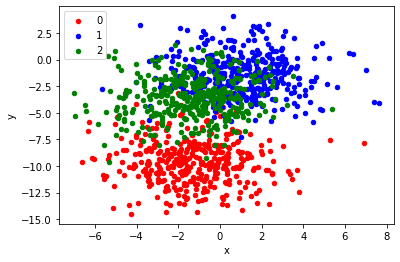

(100, 2) (1000, 2)
>Saved models/model_1.h5
['loss', 'accuracy']
[0.45081639289855957, 0.8040000200271606]
>Saved models/model_2.h5
['loss', 'accuracy']
[0.4404561221599579, 0.8169999718666077]
>Saved models/model_3.h5
['loss', 'accuracy']
[0.450729638338089, 0.8140000104904175]
>Saved models/model_4.h5
['loss', 'accuracy']
[0.4580744802951813, 0.8199999928474426]
>Saved models/model_5.h5
['loss', 'accuracy']
[0.4704795181751251, 0.8080000281333923]


In [15]:
# Generate 2d classification dataset, centers (corresponds to no. of classes) = 3 [0, 1, 2]
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# Scatter plot, dots colored by class value
df = DataFrame(dict(x = X[:,0], y = X[:,1], label = y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

# One hot encode, needed since model uses softmax activation function which predicts a vector of three elements 
# (probability that the sample belongs to each of the three classes)
y = to_categorical(y)

# Split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

# Create directory for models
if not os.path.exists('ensemble_models'):
    makedirs('ensemble_models')

# Fit and save models
n_members = 5
for i in range(n_members):
    # Fit model
    model, results = fit_model(trainX, trainy, testX, testy)
    # Save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename, overwrite=True)
    print('>Saved %s' % filename)
    print(model.metrics_names)
    print(results)
    #pyplot.plot(history.history['accuracy'], label='train')
    #pyplot.plot(history.history['val_accuracy'], label='test')
    #pyplot.legend()
    #pyplot.show()

In [16]:
# Generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# Split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

# Load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

# Define ensemble model
stacked_model = define_stacked_model(members)

Image(filename='model_graph.png',width=800, height=400)

# Fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)

# Make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis = 1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)
>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models
Stacked Test Accuracy: 0.834
